In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import sys
sys.path.append('../input/imutils-054/imutils-0.5.4')

In [4]:
# import imutils
import os
import cv2
import datetime
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import pickle

In [5]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=e822563f15781bb25ed5810cacfac6d187ea0da1cded11a173610add3f18ff7d
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [6]:
import imutils

In [7]:
data = []
labels = []
bboxes = []
# imagePaths = []

In [8]:
image_path = "../input/dataset-pollution-detection/dataset/images/"
labels_path = "../input/dataset-pollution-detection/dataset/"
train_labels_path = labels_path+"train.csv"
test_labels_path = labels_path+"test.csv"

In [9]:
classes = ["GRAFFITI","FADED SIGNAGE","POTHOLES","GARBAGE","CONSTRUCTION ROAD","BROKEN_SIGNAGE","BAD STREETLIGHT","BAD BILLBOARD","SAND ON ROAD","CLUTTER_SIDEWALK","UNKEPT_FACADE"]

In [10]:
import os
os.listdir("../input/")

['pretrained-model', 'imutils054', 'dataset-pollution-detection']

In [11]:
import csv
import cv2
with open(train_labels_path,'r') as csv_file:
    lines = len(csv_file.readlines())

with open(train_labels_path,'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in tqdm(reader, total = lines):
        image = cv2.imread(image_path+row[1])
        (h, w) = image.shape[:2]
        coords = row[3:]
        coords = [int(float(c)) for c in coords]
        label = row[0]
        Xmin = float(coords[0]) / w
        Ymin = float(coords[1]) / h
        Xmax = float(coords[2]) / w
        Ymax = float(coords[3]) / h
        
        image = load_img(image_path+row[1], target_size=(64, 64))
        image = img_to_array(image)
        
        data.append(image)
        labels.append(label)
        bboxes.append((Xmin, Ymin, Xmax, Ymax))
#         imagePaths.append(image_path)

100%|█████████▉| 19950/19951 [22:01<00:00, 15.09it/s]


In [12]:
test_data = []

In [13]:
data = np.array(data, dtype="float32") / 255.0
# convert to numpy array
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")

In [14]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [15]:
trainImages, validationImages, trainLabels, validationLabels, trainBoxes, validationBoxes = train_test_split(data, labels, bboxes, test_size=0.33, random_state=42)

In [16]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(64, 64, 3)))

2023-01-12 12:53:31.657099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 12:53:31.756958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 12:53:31.757847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 12:53:31.759309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step


In [17]:
vgg.trainable = False

In [18]:
flatten = vgg.output
flatten = Flatten()(flatten)

In [19]:
bboxHead = Dense(512, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

In [20]:
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [21]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [22]:
INIT_LR = 1e-4
NUM_EPOCHS = 150
BATCH_SIZE = 32

In [23]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

In [24]:
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [25]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBoxes
}

In [26]:
validationTargets = {
    "class_label": validationLabels,
    "bounding_box": validationBoxes
}

In [27]:
opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [28]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(validationImages, validationTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

2023-01-12 12:53:36.325902: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 656965632 exceeds 10% of free system memory.
2023-01-12 12:53:37.079405: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 656965632 exceeds 10% of free system memory.
2023-01-12 12:53:37.626191: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2023-01-12 12:53:39.466983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


418/418 [==============================] - 16s 20ms/step - loss: 1.7181 - bounding_box_loss: 0.0218 - class_label_loss: 1.6963 - bounding_box_accuracy: 0.5440 - class_label_accuracy: 0.4230 - val_loss: 1.4603 - val_bounding_box_loss: 0.0206 - val_class_label_loss: 1.4397 - val_bounding_box_accuracy: 0.5841 - val_class_label_accuracy: 0.5012
Epoch 2/150
418/418 [==============================] - 7s 17ms/step - loss: 1.4986 - bounding_box_loss: 0.0205 - class_label_loss: 1.4782 - bounding_box_accuracy: 0.5757 - class_label_accuracy: 0.4900 - val_loss: 1.3771 - val_bounding_box_loss: 0.0208 - val_class_label_loss: 1.3563 - val_bounding_box_accuracy: 0.4358 - val_class_label_accuracy: 0.5210
Epoch 3/150
418/418 [==============================] - 7s 17ms/step - loss: 1.4165 - bounding_box_loss: 0.0199 - class_label_loss: 1.3966 - bounding_box_accuracy: 0.5796 - class_label_accuracy: 0.5127 - val_loss: 1.3165 - val_bounding_box_loss: 0.0198 - val_class_label_loss: 1.2967 - val_bounding_box_a

In [29]:
model.save("model_bbox_regression_and_classification", save_format="h5")

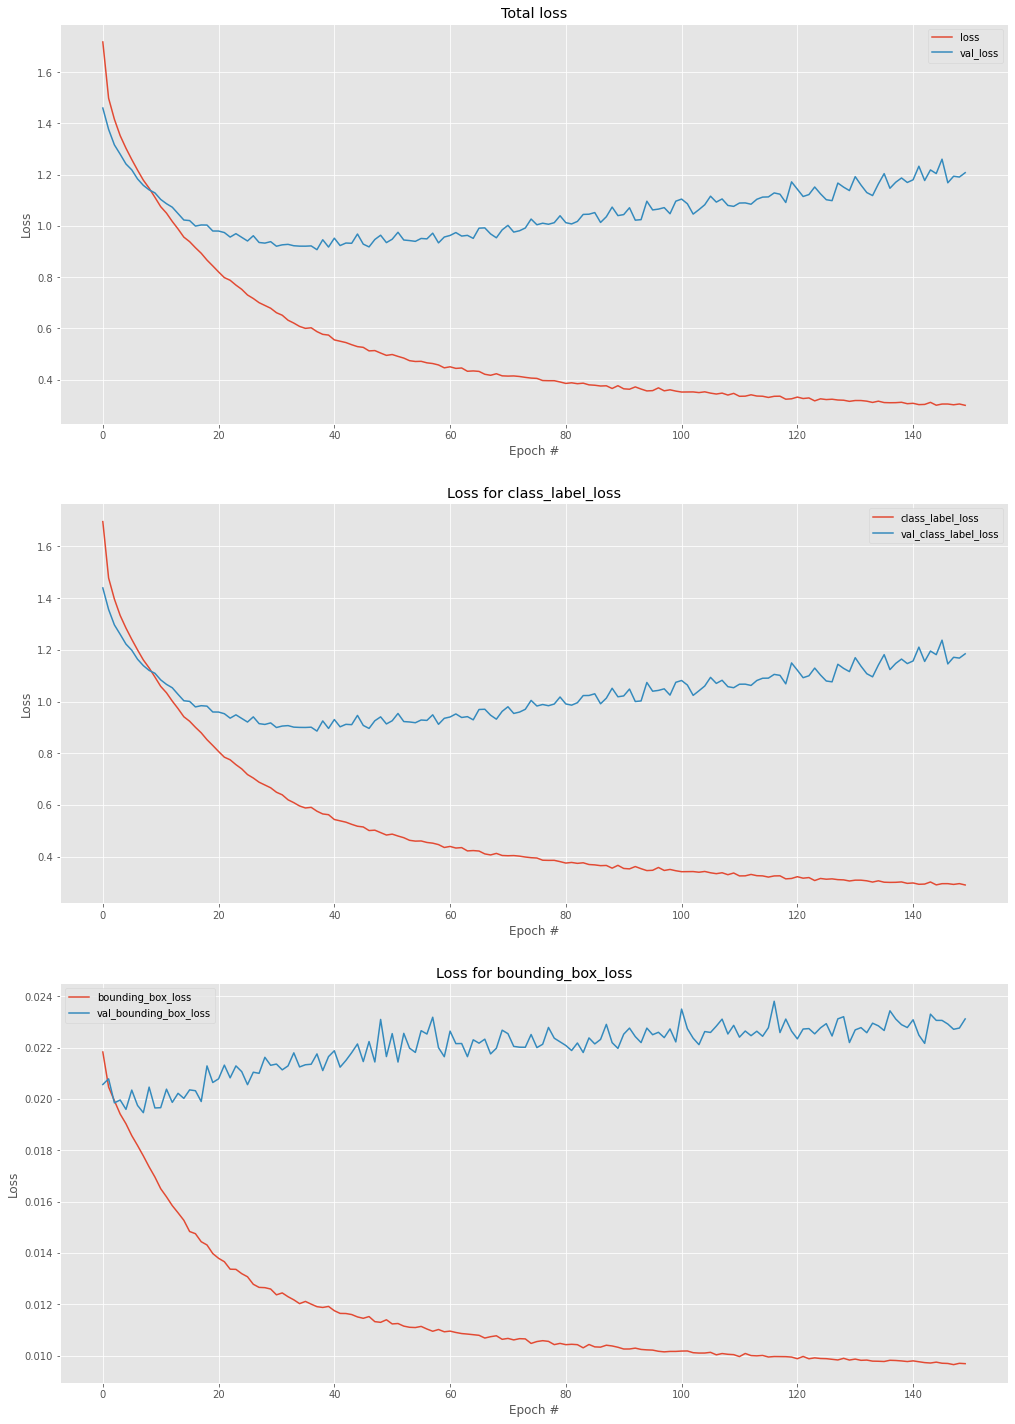

In [30]:
lossNames = ["loss", 
             "class_label_loss", 
             "bounding_box_loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(17, 25))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

In [31]:
model = load_model("./model_bbox_regression_and_classification")

In [32]:
def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

In [33]:
clases = [0.0,"GRAFFITI",1.0,"FADED SIGNAGE",2.0,"POTHOLES",3.0,"GARBAGE",4.0,"CONSTRUCTION ROAD",5.0,"BROKEN_SIGNAGE",6.0,"BAD STREETLIGHT",7.0,"BAD BILLBOARD",8.0,"SAND ON ROAD",9.0,"CLUTTER_SIDEWALK",10.0,"UNKEPT_FACADE"]

In [34]:
lst = Convert(clases)

In [35]:
# print(lst['3.0'])

In [36]:
with open(test_labels_path,'r') as csv_files:
    test_lines = len(csv_files.readlines())

with open(test_labels_path,'r') as csvfiles:
    test_reader = csv.reader(csvfiles, delimiter=',')
    next(test_reader)
    for rows in tqdm(test_reader, total = test_lines):
        test_image = load_img(image_path+rows[0], target_size=(64, 64))
        test_image = img_to_array(test_image)
        test_data.append(test_image)

100%|█████████▉| 2092/2093 [01:21<00:00, 25.74it/s]


In [37]:
# (boxPreds, labelPreds) = model.predict(test_data[0])
test_data = np.array(test_data, dtype="float32") / 255.0

In [38]:
i=0
ans = [["class", "image_path", "name", "xmax", "xmin", "ymax", "ymin"]]
with open(test_labels_path,'r') as csvfi:
    test_reade = csv.reader(csvfi, delimiter=',')
    next(test_reade)
    
    for roww in test_reade:
        im = test_data[i].reshape(1,64,64,3)
#         print(im.shape)
        (boxPreds, labelPreds) = model.predict(im)
        (startX, startY, endX, endY) = boxPreds[0]
        h = np.argmax(labelPreds, axis=1)
        label = lb.classes_[h][0]
        startX = int(startX * w)
        startY = int(startY * h)
        endX = int(endX * w)
        endY = int(endY * h)
#         print(type(float((label))))
        ans.append([label, roww[0], lst[float((label))], startX, startY, endX, endY])
        i = i+1
        
with open("./submission.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    for a in ans:
        writer.writerow(a)
f.close()
    